In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
from gensim.models import KeyedVectors
import spacy
from unidecode import unidecode
import model_utils
import constants
import os

In [2]:
word2vec = KeyedVectors.load("./../word2vec/word2vec_100_3_polish.bin")

In [3]:
def tokens_to_vector(sentence):
    vector_size = word2vec.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sentence:
        if w in word2vec:
            ctr += 1
            wv_res += word2vec[w]
    wv_res = wv_res/ctr
    return wv_res

In [4]:
# spacy_model = spacy.load("pl_core_news_sm")

In [5]:
# # Stop words
# stop_words = spacy_model.Defaults.stop_words.copy()
# stop_words.remove("nie")
# print(stop_words)

In [6]:
# len(stop_words)

In [7]:
# punctuations = string.punctuation
# print(punctuations)

In [8]:
# # Tokenizer
# def spacy_tokenizer(sentence):
#     doc = spacy_model(sentence)

#     # Lemmatizing each token and converting each token into lowercase
#     mytokens = [ word.lemma_.lower().strip() for word in doc ]

#     # Removing stop words and punctuation
#     mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

#     # return preprocessed list of tokens
#     return mytokens

In [9]:
# df = pd.read_json('./../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')
# df = df.drop(columns=['article_link', 'headline'])
# df

In [10]:
# df['headline_pl'] = df['headline_pl'].apply(unidecode)
# df

In [11]:
# df['tokens'] = df['headline_pl'].apply(spacy_tokenizer)
# df.to_json(r'./utils/tokenized_dataset_no_diacritics.json.json')

In [13]:
tokenized_sentences_df = pd.read_json('./utils/tokenized_dataset_no_diacritics.json')
tokenized_sentences = tokenized_sentences_df['tokens'].values.tolist()
is_sarcastic_labels = tokenized_sentences_df['is_sarcastic'].values.tolist()

In [14]:
vectors = [tokens_to_vector(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

In [15]:
X = np.array(vectors)
Y = np.array(is_sarcastic_labels)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=0.5, random_state=42)

In [17]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [18]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [19]:
# Model parameters
training_number = 1
model_name = 'sarcasm_pl_word2vec_external_no_diacritics'
training_name = model_name
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)
batch_size = 32

In [20]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [21]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=batch_size, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20
711/716 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.6450
Epoch 1: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_external_no_diacritics\sarcasm_pl_word2vec_external_no_diacritics\cp-0001.ckpt
716/716 [==============================] - 3s 3ms/step - loss: 0.6290 - accuracy: 0.6452 - val_loss: 0.6077 - val_accuracy: 0.6723
Epoch 2/20
716/716 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.6903
Epoch 2: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_external_no_diacritics\sarcasm_pl_word2vec_external_no_diacritics\cp-0002.ckpt
716/716 [==============================] - 2s 3ms/step - loss: 0.5876 - accuracy: 0.6903 - val_loss: 0.6017 - val_accuracy: 0.6785
Epoch 3/20
693/716 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.7041
Epoch 3: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_external_no_diacritics\sarcasm_pl_word2vec_external_no_diacritics\cp-0003.ck

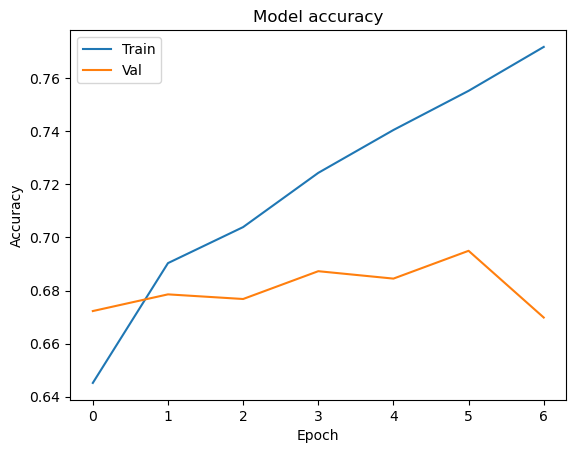

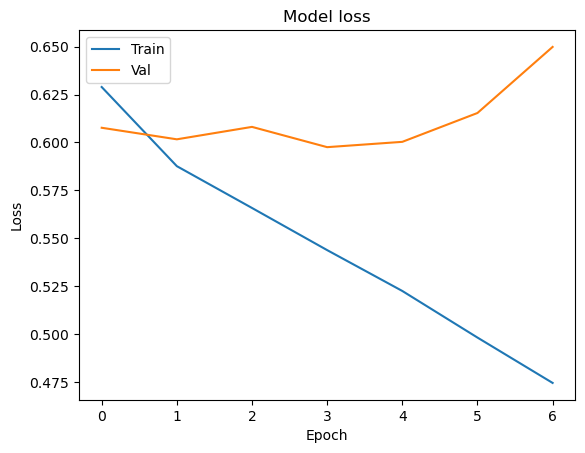

In [22]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [23]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

90/90 [==============================] - 0s 3ms/step


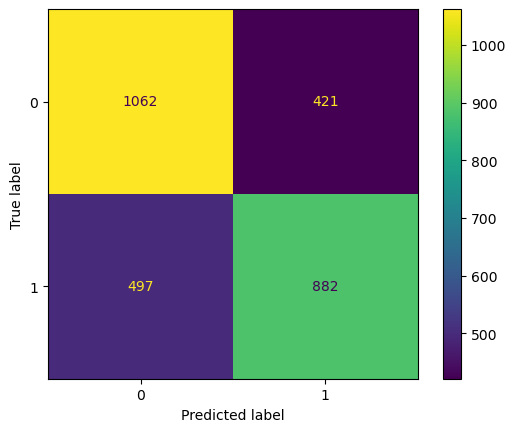

In [24]:
class_preds = model_utils.get_class_preds(best_model, X_test, model_returns_logits=False)
model_utils. plot_and_save_conf_matrix(class_actual=Y_test,
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [25]:
# Evaluation
best_model.evaluate(X_test, Y_test, batch_size=batch_size)

90/90 [==============================] - 0s 1ms/step - loss: 0.6023 - accuracy: 0.6792


[0.6022509932518005, 0.6792452931404114]

In [26]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number,
                       saved_models_dir=constants.SAVED_MODEL_LOCATION,
                       default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_word2vec_external_no_diacritics_1\1\assets
